In [67]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom

print(tf.__version__) # 2.6.0

2.6.0


In [68]:
from pathlib import Path

# Obter todas as fotos de caule
path = Path( 'fotos/by_section' )
caule = list( path.glob( 'caule/*.jpg' ) )
img_count = len( caule )

In [69]:
# Vou usar o seguinte esquema:
# 80% das imagens serão usadas para treinar a ML
# 20% para validar a precisão
batch_size = 50
img_width = 100
img_height = 100

In [70]:
# Criar dataset para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 396 files belonging to 4 classes.
Using 317 files for training.


In [71]:
# Criar dataset para validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 396 files belonging to 4 classes.
Using 79 files for validation.


In [72]:
class_names = train_ds.class_names
print( class_names )

['caule', 'flor', 'folha', 'fruto']


In [73]:
# Remover canal gama RGB (vai basicamente deixar todas as fotos em preto e branco)
normalization_layer = Rescaling(1. / 255)

In [74]:
# Normalizar imagens
normalized_ds = train_ds.map( lambda x, y: (normalization_layer(x), y) )

# Checar se a imagem agora está normalizada
# obs: uma imagem normalizada deve ter os valores
# dos pixels entre 0.0 e 1.0
image_batch, labels_batch = next( iter(normalized_ds) )
first_image = image_batch[0]
print( np.min(first_image), np.max(first_image) )

0.0 0.95294124


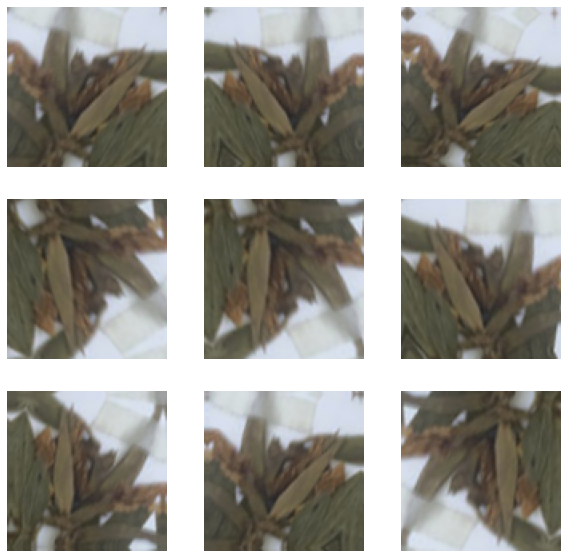

In [75]:
# Aumento de dados
# como o dataset de imagens é bem pequeno, vamos aplicar
# técnicas como zoom, espelhar e rotacionar as imagens
# existentes, criando cópias com essas modificações
# para serem inclusas no treinamento
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Visualização das imagens com modificações
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [76]:
# Criação do modelo
num_classes = 4
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, 3,padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [77]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Exibir resumo do modelo
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 64)      

In [78]:
# Treinar o modelo
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
7/7 [==============================] - 15s 2s/step - loss: 1.5184 - accuracy: 0.2713 - val_loss: 1.3913 - val_accuracy: 0.2152
Epoch 2/100
7/7 [==============================] - 14s 2s/step - loss: 1.3669 - accuracy: 0.3628 - val_loss: 1.3596 - val_accuracy: 0.2785
Epoch 3/100
7/7 [==============================] - 13s 2s/step - loss: 1.3431 - accuracy: 0.3596 - val_loss: 1.3164 - val_accuracy: 0.3418
Epoch 4/100
7/7 [==============================] - 12s 2s/step - loss: 1.2900 - accuracy: 0.3785 - val_loss: 1.2734 - val_accuracy: 0.3924
Epoch 5/100
7/7 [==============================] - 12s 2s/step - loss: 1.2716 - accuracy: 0.3785 - val_loss: 1.2567 - val_accuracy: 0.4684
Epoch 6/100
7/7 [==============================] - 12s 2s/step - loss: 1.2282 - accuracy: 0.4448 - val_loss: 1.2379 - val_accuracy: 0.4684
Epoch 7/100
7/7 [==============================] - 11s 2s/step - loss: 1.1896 - accuracy: 0.4385 - val_loss: 1.2244 - val_accuracy: 0.4810
Epoch 8/100
7/7 [==========

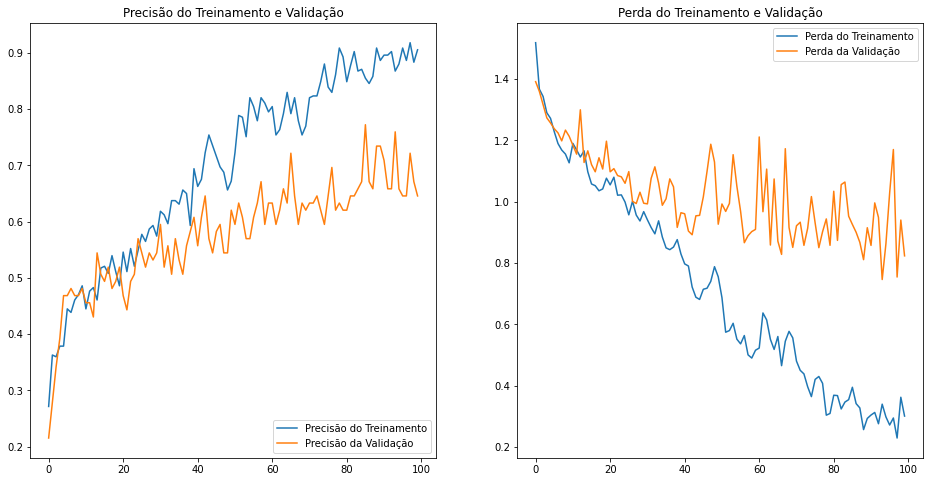

In [79]:
# Estatisticas sobre o treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotar gráficos de precisão e perda
plt.figure( figsize=(16, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão do Treinamento')
plt.plot(epochs_range, val_acc, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.title('Precisão do Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda do Treinamento')
plt.plot(epochs_range, val_loss, label='Perda da Validação')
plt.legend(loc='upper right')
plt.title('Perda do Treinamento e Validação')
plt.show()

In [80]:
# Testar a ML
# aqui estou usando 4 imagens, uma para cada classe, removidas da pasta 'fotos'
# para verificar se a ML realmente funciona
test_path = Path( 'fotos/testes' )
test_images = list( test_path.glob( '*.jpg' ) )
for image in test_images:
    img = tf.keras.utils.load_img(
        image, target_size=(img_width, img_height)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax( predictions[0] )
    print( f"Essa imagem provavelmente pertence à classe '{ class_names[ np.argmax(score) ] }' com uma confiança de {(100 * np.max(score)):.2f}%" )

Essa imagem provavelmente pertence à classe 'caule' com uma confiança de 78.16%
Essa imagem provavelmente pertence à classe 'flor' com uma confiança de 98.29%
Essa imagem provavelmente pertence à classe 'folha' com uma confiança de 99.74%
Essa imagem provavelmente pertence à classe 'folha' com uma confiança de 79.16%


In [ ]:
# Exportar a ML
from pathlib import Path
ROOT_DIR = Path('..').resolve()
MODELS_PATH = Path( ROOT_DIR, 'models' )
MODEL_PATH = Path( MODELS_PATH, 'section.h5' )

model.save( MODEL_PATH )